Проект команды **paranormal** в рамках домашнего задания Летней Школы **МТС.Тета**, направление "Машинное обучение"

#### Загрузка и настройка необходимых библиотек

In [ ]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
import sklearn.metrics as metrics
import time
from sklearn.inspection import permutation_importance

In [ ]:
sns.set_theme(style='whitegrid', palette='deep')
warnings.filterwarnings('ignore')

## 1. Анализ данных

In [ ]:
# путь к данным
pyth = 'data/diabetes.csv'

### 1.1. Предобработка датасета

In [ ]:
# загрузка данных
data = pd.read_csv(pyth)
# убираем дубликаты
data = data.drop_duplicates()
# приводим в однообразное написание название переменных
data.columns = [c.replace(' ', '_').lower() for c in data.columns]
# заменяем значения 'Female', 'No' и 'Negative' на 0, 'Male', 'Yes' и 'Positive' - на 1
data = data.replace(["Yes", 'No', 'Male', 'Female', 'Positive', 'Negative'], [1, 0, 1, 0, 1, 0])
# сохраняем загруженные данные в отдельный датасет
df_diabetes = data.copy()
df_diabetes.head(5)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


#### Переменные:
- age - возраст
- gender - пол
- polyuria - полиурия (увеличенное образование мочи)
- polydipsia - полидипсия (неутолимая жажда)
- sudden weight loss - внезапная потеря веса
- weakness - слабость
- polyphagia - полифагия (повышенный аппетит)
- genital thrush - генитальная молочница
- visual blurring - расплывчатость зрения
- itching - зуд
- irritability - раздражительность
- delayed healing - медленное заживление ран
- partial paresis - частичный парез (потеря мышечной силы)
- muscle stiffness - жесткость мышц
- alopecia - алопеция (выпадение волос)
- obesity - ожирение

### 2.2. Разведочный анализ данных

In [ ]:
print('Уникальные значения переменных')
for col in df_diabetes.columns:
    print(col, df_diabetes[col].unique())

Уникальные значения переменных
age [40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
gender [1 0]
polyuria [0 1]
polydipsia [1 0]
sudden_weight_loss [0 1]
weakness [1 0]
polyphagia [0 1]
genital_thrush [0 1]
visual_blurring [0 1]
itching [1 0]
irritability [0 1]
delayed_healing [1 0]
partial_paresis [0 1]
muscle_stiffness [1 0]
alopecia [1 0]
obesity [1 0]
class [1 0]


In [ ]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 251 non-null    int64
 1   gender              251 non-null    int64
 2   polyuria            251 non-null    int64
 3   polydipsia          251 non-null    int64
 4   sudden_weight_loss  251 non-null    int64
 5   weakness            251 non-null    int64
 6   polyphagia          251 non-null    int64
 7   genital_thrush      251 non-null    int64
 8   visual_blurring     251 non-null    int64
 9   itching             251 non-null    int64
 10  irritability        251 non-null    int64
 11  delayed_healing     251 non-null    int64
 12  partial_paresis     251 non-null    int64
 13  muscle_stiffness    251 non-null    int64
 14  alopecia            251 non-null    int64
 15  obesity             251 non-null    int64
 16  class               251 non-null    int64
dt

<div class="alert alert-block alert-info"><b>
Пропущенных значений нет, нет необходимости в обработке пропусков
</div> 

In [ ]:
df_diabetes.describe()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,48.864542,0.637450,0.525896,0.494024,0.414343,0.633466,0.466135,0.266932,0.442231,0.505976,0.282869,0.498008,0.446215,0.390438,0.358566,0.175299,0.689243
std,12.526036,0.481697,0.500327,0.500963,0.493592,0.482820,0.499849,0.443241,0.497644,0.500963,0.451293,0.500995,0.498092,0.488823,0.480538,0.380982,0.463728
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class="alert alert-block alert-info"><b>
    <p>В датасете данные пациентов в возрасте от 16 до 90 лет, медиана - 48 лет, средний 48.9 лет. </p>
    <p>Остальные переменные - бинарные. </p>
    <p>Датасет по целевому классу достаточно сбалансирован: 69% на 31%.
</div> 

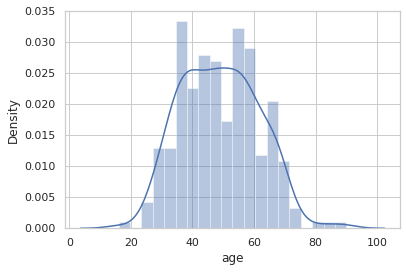

In [ ]:
sns.distplot(df_diabetes['age'], bins=20);

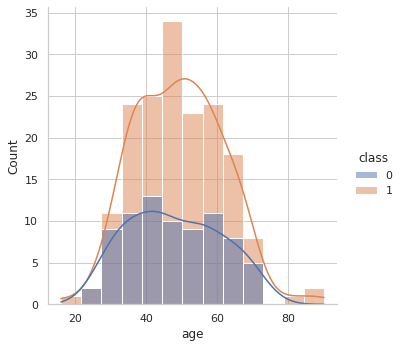

In [ ]:
sns.displot(data=data, x='age', hue='class', kde = True);

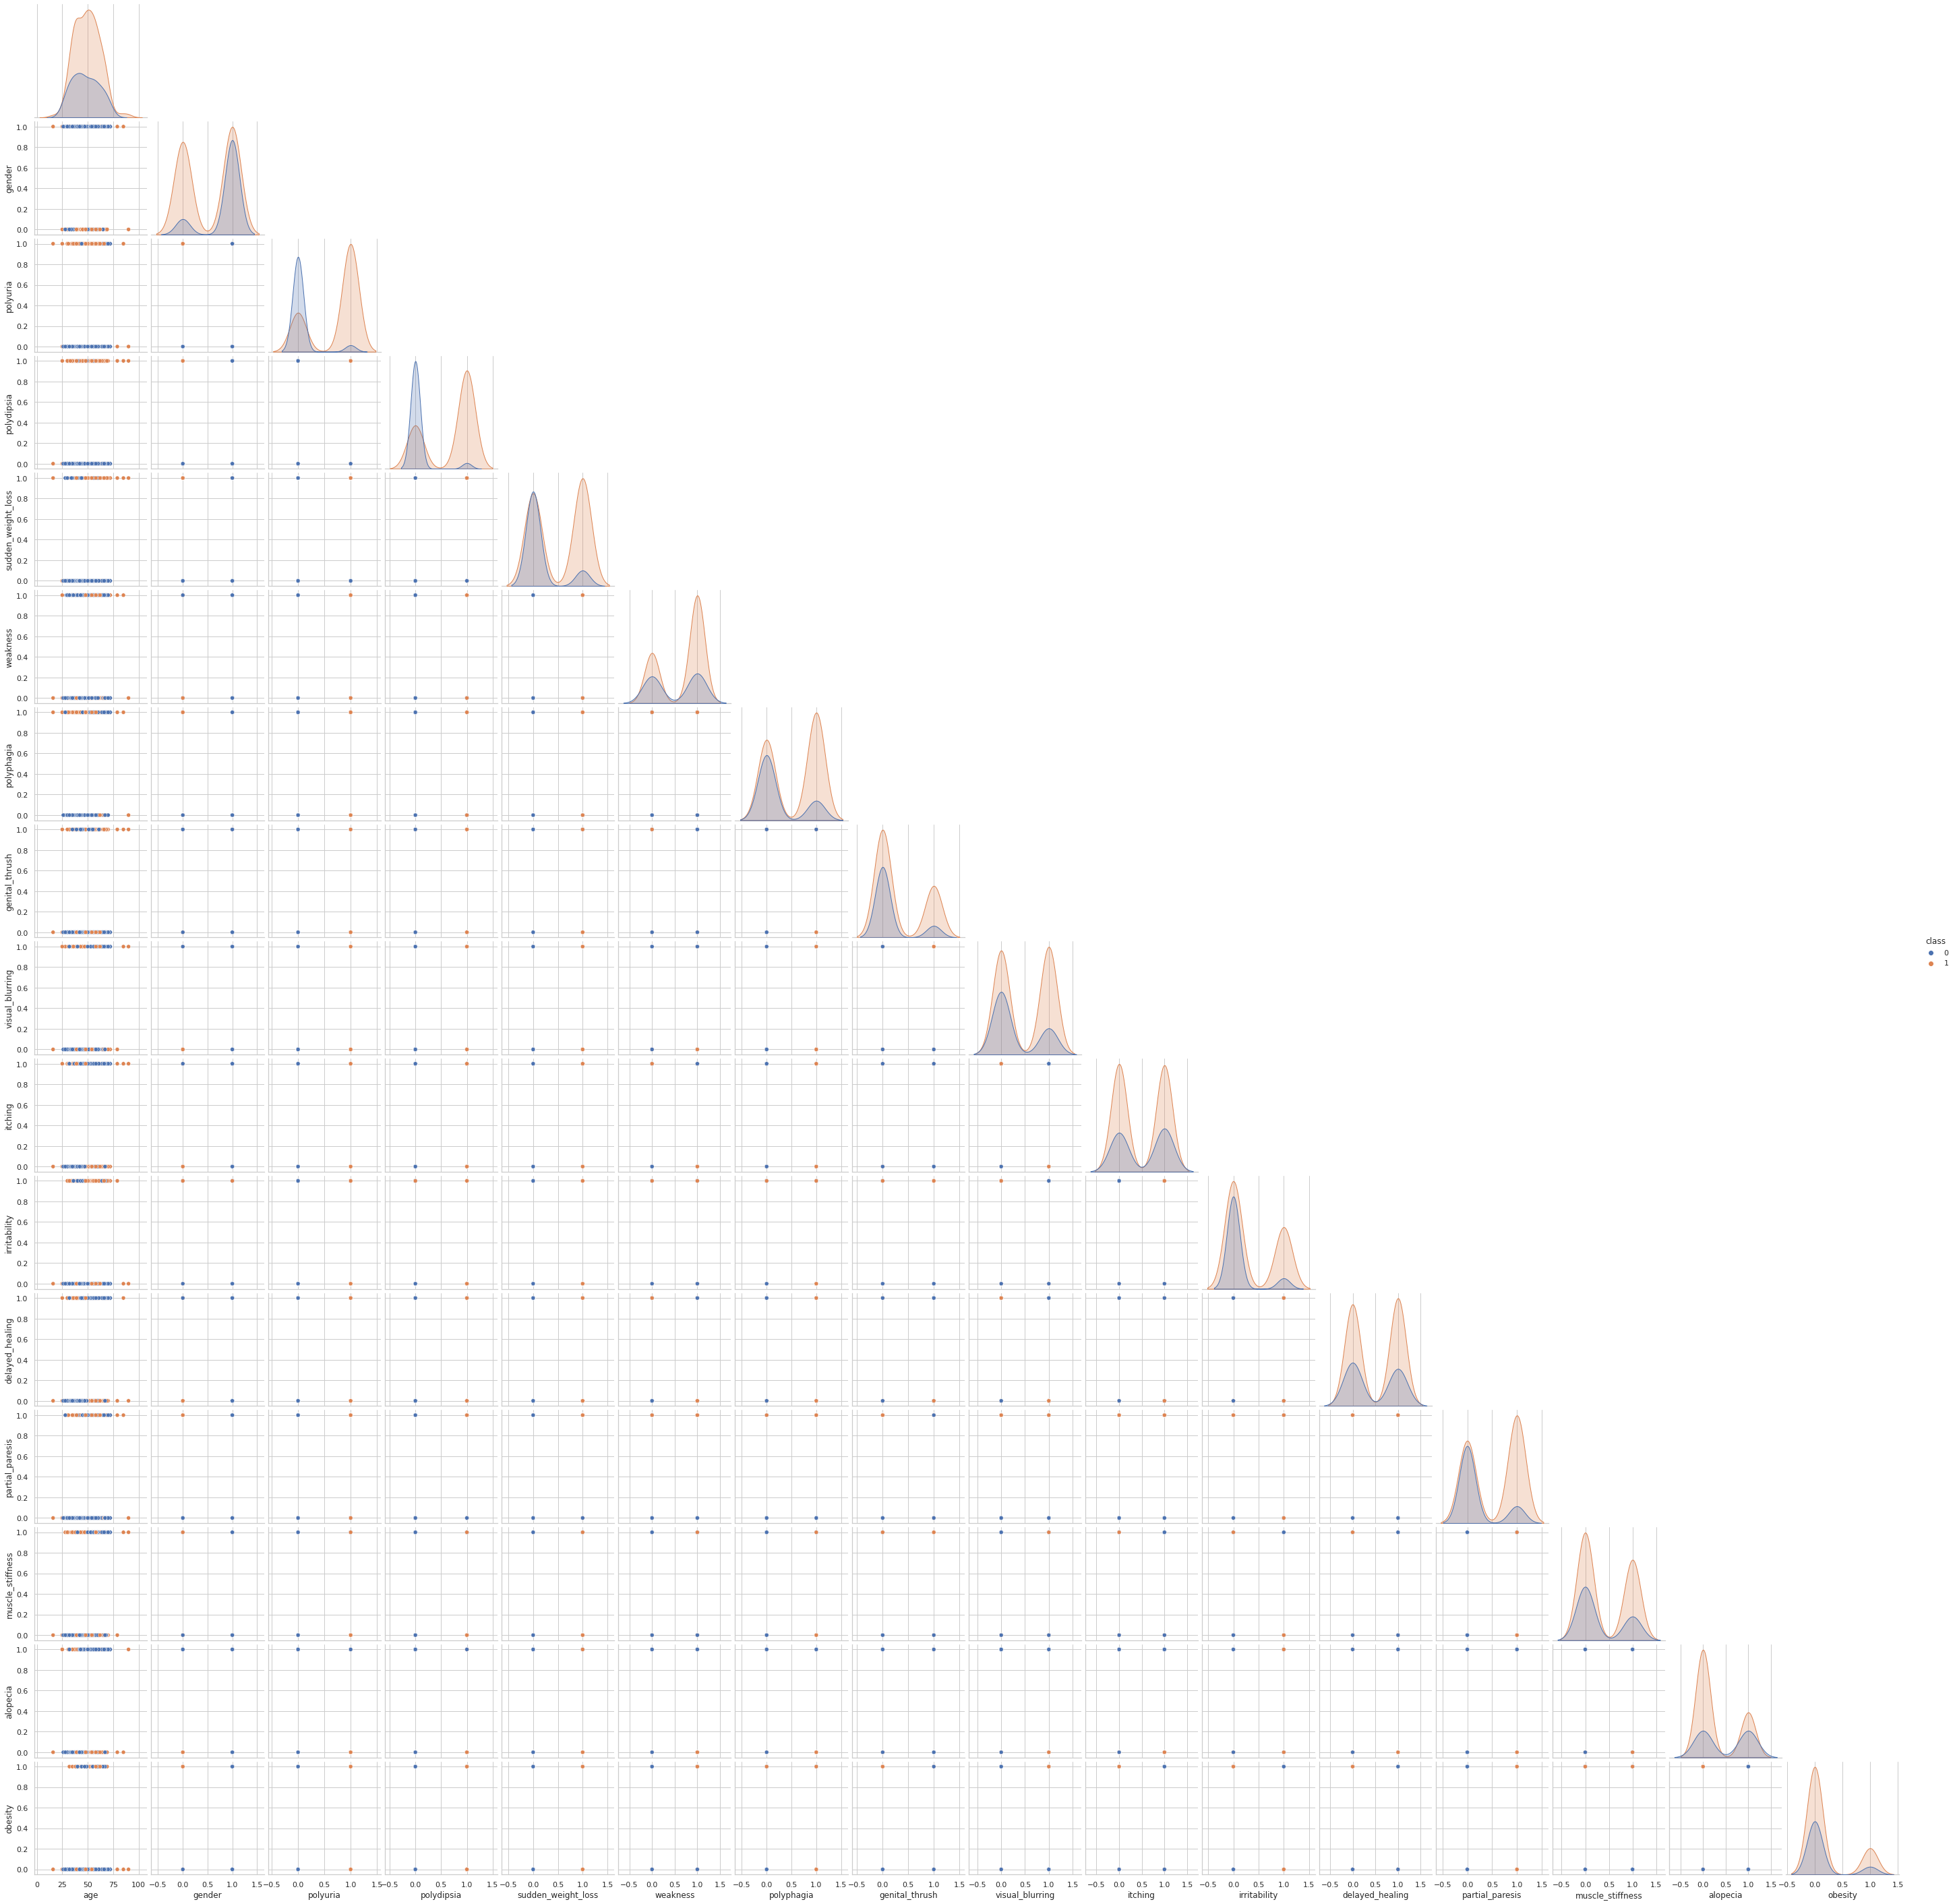

In [ ]:
sns.pairplot(df_diabetes, hue='class', corner=True);

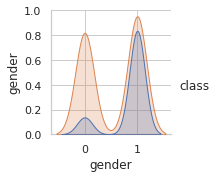

In [ ]:
sns.pairplot(df_diabetes[['gender', 'class']], hue='class');

In [ ]:
round(df_diabetes[df_diabetes['class'] == 1].groupby(['gender'])['weakness'].count() / df_diabetes[df_diabetes['class'] == 1]['weakness'].count() * 100, 2)

gender
0    46.24
1    53.76
Name: weakness, dtype: float64

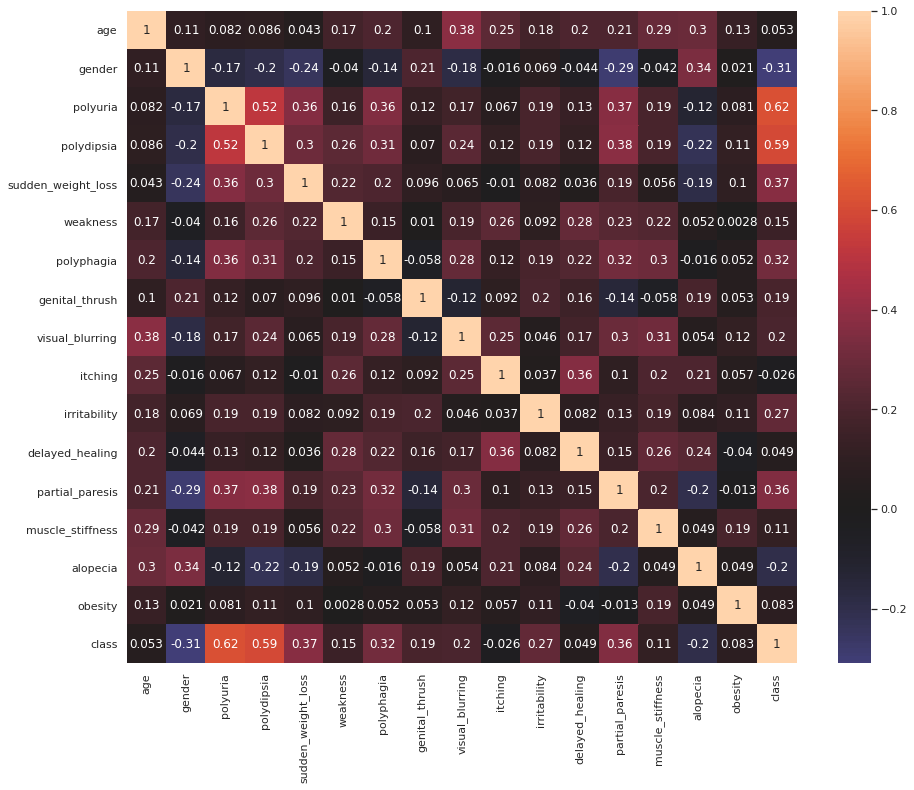

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df_diabetes.corr(method='pearson'), center=0, square=False, annot=True, ax=ax);

In [ ]:
pointbiserialr(df_diabetes.iloc[:, 1], df_diabetes.age)

PointbiserialrResult(correlation=0.10916809206933127, pvalue=0.0843335297777791)

<div class="alert alert-block alert-info"><b>
    Основные выводы
</div> 

<div class="alert alert-block alert-info"><b>
    
1) Диабет, особенно 2-го типа, наиболее распространен среди мужчин, чем среди женщин. https://www.news-medical.net/health/Diabetes-in-Men-versus-Women.aspx

2) Целевой класс сильно коррелирует с переменными полиурия и полидипсия.  https://www.jdrf.org/t1d-resources/about/symptoms/frequent-urination/

3) Также целевой класс коррелирует с внезапной потерей веса. https://www.medicinenet.com/is_weight_loss_caused_by_diabetes_dangerous/ask.htm

4) Перечисленные в исходных данных признаки (полиурия, полидипсия, внезапная потеря веса, слабость, повышенный аппетит, ожирание, зуд и т.п.) являются симптомами сахарного диабета.  Стоит отметить, что чем выше стадия сахарного диабета, тем заметнее проявление симптомов. 

5) Указан признак полиурия, но помимо этого возможно также ночное недержание. Можно добавить и такие признаки, как онемение и покалывание в руках и ногах, повышеная потливость, быстрая утомляемость, нехватка энергии, сильная усталость и сухость во рту из-за чувства жажды.

6) На представленных данных можно построить модель. В будущем в данные можно будет добавить указанные выше симптомы, а также расширить географию сбора данных.

7) Признаки не противоречат друг другу, данные соответствуют гипотезе.

</div> 

## 2. Моделирование

<div class="alert alert-block alert-info"><b>
    Решая поставленную задачу, мы испробовали несколько методов машинного обучения, включая логистическую регрессию, градиентный бустинг и случайный лес. Лучший результат на наших данных показал случайный лес по метрике F1.</div>

In [ ]:
X, y = df_diabetes.drop('class', 1), df_diabetes['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
def print_metrics(y_true, y_pred):
    print(f'f1_score: {f1_score(y_true, y_pred):.4f}')
    print(f'recall_score: {recall_score(y_true, y_pred):.4f}')
    print(f'precision_score: {precision_score(y_true, y_pred):.4f}')

In [ ]:
def get_metrics(y_true, y_pred):
    return(np.array([f1_score(y_true, y_pred), recall_score(y_true, y_pred),precision_score(y_true, y_pred)]))

### baseline - логистичекая регрессия  

In [ ]:
clf_log = LogisticRegression(random_state=42)
clf_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_log  = clf_log.predict(X_test)

Измерим метрики качества baseline классификатора.

In [ ]:
print_metrics(y_test, clf_log.predict(X_test))

f1_score: 0.8667
recall_score: 0.9512
precision_score: 0.7959


[Text(0, 0.5, 'healthy'), Text(0, 1.5, 'sick')]

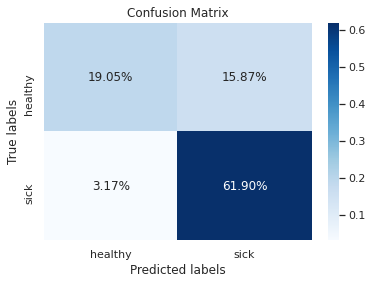

In [ ]:
conf_mat = confusion_matrix(y_test, clf_log.predict(X_test))
ax = plt.subplot()
sns.heatmap(conf_mat / np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(['healthy', 'sick'])
ax.yaxis.set_ticklabels(['healthy', 'sick'])

### Лучшая модель - случайный лес

In [ ]:
param_grid = {
    'n_estimators': np.arange(5, 51, 15),
    'max_depth': np.arange(5, 51, 15),
    'min_samples_split': np.arange(2, 11, 4),
    'min_samples_leaf': np.arange(1, 10, 4),
    'max_samples': np.arange(0.1, 0.99, 0.23), 
}

In [ ]:
%%time
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
cv = GridSearchCV(rf, param_grid, cv=3).fit(X_train, y_train)

CPU times: user 1min 44s, sys: 5.56 s, total: 1min 49s
Wall time: 5min 5s


In [ ]:
cv.best_params_

{'max_depth': 20,
 'max_samples': 0.56,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 35}

In [ ]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.56,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_forest = cv.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_forest)

[Text(0, 0.5, 'healthy'), Text(0, 1.5, 'sick')]

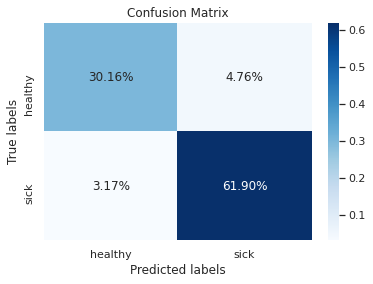

In [ ]:
ax = plt.subplot()
sns.heatmap(conf_mat / np.sum(conf_mat), annot=True, fmt='.2%', cmap='Blues', ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(['healthy', 'sick'])
ax.yaxis.set_ticklabels(['healthy', 'sick'])

Измерим метрики качества получившегося классификатора.

In [ ]:
print_metrics(y_test, y_pred_forest)

f1_score: 0.9398
recall_score: 0.9512
precision_score: 0.9286


<div class="alert alert-block alert-info"><b>
    Полученное значение F1 меры соответствует ожидаемому качеству модели. </div> 

***Рассмотрим, насколько хорошо откалибрована модель.***

Балл Бриера можно использовать для оценки того, насколько хорошо откалиброван классификатор.

Оценка Бриера — это правильная функция оценки, которая измеряет точность вероятностных прогнозов. Это применимо к задачам, в которых прогнозы должны назначать вероятности набору взаимоисключающих дискретных результатов.

Потеря по шкале Бриера также составляет от 0 до 1, и чем ниже значение (средняя квадратичная разница меньше), тем точнее прогноз.

In [ ]:
print("Оценка Бриера = ", round(brier_score_loss(y_test, cv.best_estimator_.predict_proba(X_test)[:,1]),3))

Оценка Бриера =  0.067


**Модель хорошо откалибрована!**

Рассмотрим, как выглядит ROC-кривая и чему равен ROC AUC.

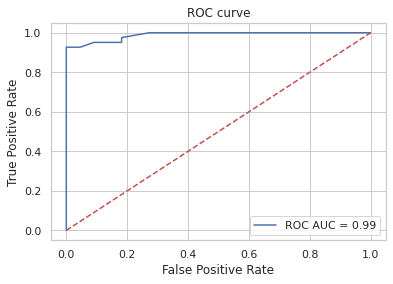

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'ROC AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**ROC AUC = 0.99**

Получили классификатор хорошего качества!

### Оценим, на сколько процентов новая(лучшая) модель лучше baseline по качеству 

Для этого воспользуемся формулой: 

$\frac{best\_score - baseline\_score}{baseline\_score}*100\%$, где

- $best\_score$ - качество лучшей модели;

- $baseline\_score$ - качество модели baseline.




In [ ]:
increase_quality = (get_metrics(y_test, y_pred_forest) - get_metrics(y_test, y_pred_log))/get_metrics(y_test, y_pred_log)*100
print(f'increase f1_score: {increase_quality[0]:.2f}','%', sep = '')
print(f'increase recall_score: {increase_quality[1]:.2f}','%', sep = '')
print(f'increase precision_score: {increase_quality[2]:.2f}','%', sep = '')

increase f1_score: 8.43%
increase recall_score: 0.00%
increase precision_score: 16.67%


Улучшили оптимизируемую метрику качества **f1** больше, чем на **8%**.


### Важность признаков для лучшей модели

Рассмотрим 2 способа оценки важности признаков.

#### Feature importance based on mean decrease in impurity

Случайный лес состоит из нескольких деревьев решений. Каждый узел в деревьях решений - это условие для одного признака, предназначенное для разделения набора данных на два, чтобы аналогичные значения ответа попадали в один и тот же набор. Мера, на основе которой выбирается (локально) оптимальное условие, называется критерием информативности. Используем **критерий информативности Джини**. Таким образом, при обучении дерева можно вычислить, насколько каждый признак уменьшает критерий информативности в дереве. Для леса уменьшение критерия информативности от каждого объекта может быть усреднено, и объекты ранжируются в соответствии с этой мерой.

*Важность признаков обеспечивается подобранным атрибутом feature_importances_, и они вычисляются как среднее значение и стандартное отклонение накопления уменьшения критерия информативности в каждом дереве.* 

In [ ]:
start_time = time.time()
importances = cv.best_estimator_.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in cv.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.106 seconds


Построим график важности признаков на основе mean decrease in impurity:

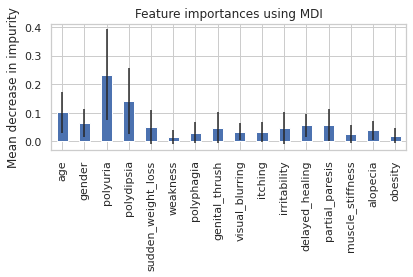

In [ ]:
forest_importances = pd.Series(importances, index=df_diabetes.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

На основе mean decrease in impurity получили, что самыми важными признаками являются polyuria - полиурия (увеличенное образование мочи) и
polydipsia - полидипсия (неутолимая жажда).

#### Feature importance based on feature permutation (Важность признаков на основе перестановки признаков)

Еще один популярный метод выбора признаков - это прямое измерение влияния каждого признака на точность модели. Общая идея состоит в том, чтобы переставить значения каждого признака и измерить, насколько перестановка снижает точность модели. Очевидно, что для неважных переменных перестановка не должна иметь большого влияния на точность модели, в то время как перестановка важных переменных должна значительно ее уменьшить.

Вычисление важности признаков полной перестановки более затратно. Признаки перемешиваются n=10 раз, и модель перестраивается, чтобы оценить их важность.

In [ ]:
start_time = time.time()
result = permutation_importance(
    cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df_diabetes.columns[:-1])

Elapsed time to compute the importances: 8.771 seconds


Построим график важности признаков на основе перестановки признаков:

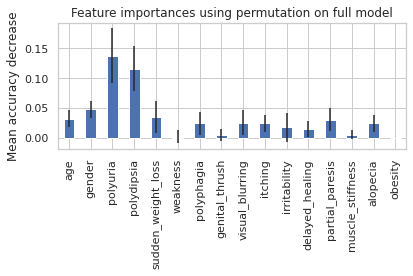

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

На основе перестановки признаков получили результат, как при использовании mean decrease in impurity, ***самыми важными признаками являются polyuria - полиурия (увеличенное образование мочи) и
polydipsia - полидипсия (неутолимая жажда)***.



### Стабильность модели и скорость её деградации

#### Оценка стабильности модели с помощью кросс-валидации

С помощью cross-validation можно оценить 
стабильность модели:
- меняется ли качество от фолда к фолду?
- меняется ли feature importance от фолда к фолду?


In [ ]:
N_fold = 5
n_scores = cross_val_score(cv.best_estimator_, 
                           X_train,
                           y_train,
                           scoring='f1',
                           cv=N_fold,
                           n_jobs=-1)


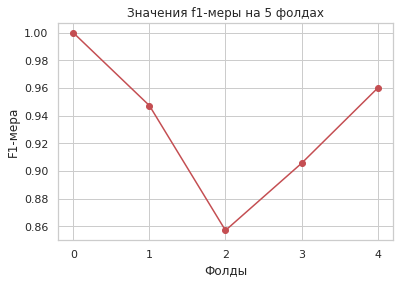

In [ ]:
plt.plot(range(N_fold),n_scores, c='r')
plt.scatter(range(N_fold),n_scores, c='r')
plt.title('Значения f1-меры на {} фолдах'.format(N_fold))
plt.ylabel('F1-мера')
plt.xlabel('Фолды')
plt.xticks(range(N_fold))
plt.grid
plt.show()

Качество от фолда к фолду меняется не очень сильно - модель достаточно устойчива!

Рассмотрим, как меняется важность признаков от фолда к фолду с помощью оценки важности признаков на основе перестановок признаков.

Elapsed time to compute the importances: 8.432 seconds


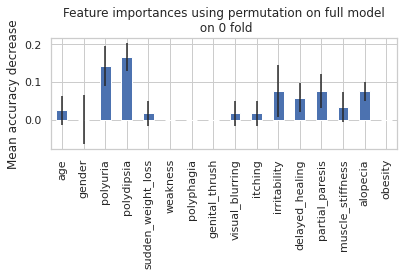

Elapsed time to compute the importances: 8.454 seconds


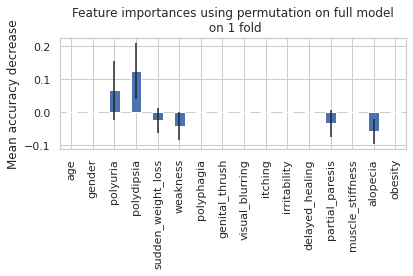

Elapsed time to compute the importances: 8.565 seconds


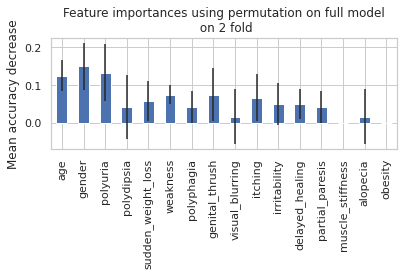

Elapsed time to compute the importances: 8.450 seconds


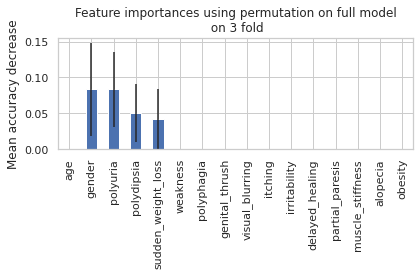

Elapsed time to compute the importances: 8.436 seconds


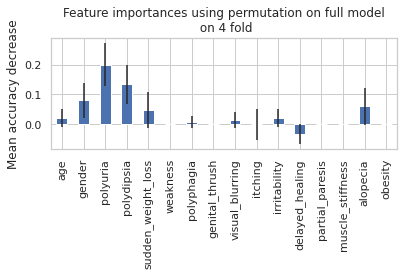

In [ ]:
bias_fold = len(y_test)//N_fold
for i in range(N_fold):
  start_time = time.time()
  if (i+1)!=N_fold:
    result = permutation_importance(
        cv.best_estimator_, X_test[i*bias_fold:(i+1)*bias_fold], y_test[i*bias_fold:(i+1)*bias_fold], 
        n_repeats=10, random_state=42, n_jobs=2)
  else:
    result = permutation_importance(
      cv.best_estimator_, X_test[i*bias_fold:], y_test[i*bias_fold:], n_repeats=10, random_state=42, n_jobs=2)
  elapsed_time = time.time() - start_time
  print(f"Elapsed time to compute the importances: "
        f"{elapsed_time:.3f} seconds")

  forest_importances = pd.Series(result.importances_mean, index=df_diabetes.columns[:-1])

  fig, ax = plt.subplots()
  forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
  ax.set_title("Feature importances using permutation on full model\n on {} fold".format(i))
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

На всех фолдах polyuria является важным признаком. Gender и polydipsia тоже являются важными признаками, но от фолда к фолду их важность меняется.

*Можем считать модель стабильной!*

#### Оценка стабильности объектов(популяции) с помощью индекса PSI

Одним из решений для оценки изменения популяции является индекс стабильности популяции или population stability index.

Поскольку изменение распределения не обязательно должно сопровождаться изменением зависимой переменной, индекс PSI также можно использовать для изучения сходства/различия между любыми выборками. Например, для сравнения уровня образования, дохода и состояния здоровья двух или нескольких популяций в социально-демографических исследованиях.

Простыми словами, PSI сравнивает распределение переменной в новом наборе данных с набором тренировочных данных, который использовался при разработке модели. Также хотелось бы отметить, что основной сценарий применение алгоритма – оценка изменения распределения на выборке отличной по времени от той на которой проводилась разработка (точное ее название Out Of Time или OOT).

Для получения вывода о том, что необходимо делать с моделью нужно использовать следующие интервалы:

- PSI менее 10% показывает отсутствие значимого изменения в текущей выборке (Изменения в данных незначительны и модель не требует доработки);
- PSI в диапазоне от 10 до 25% свидетельствует о незначительном изменении, которые необходимо исследовать (Есть изменения в данных и модель требует незначительной доработки);
- PSI более 25% говорит о значительном смещении популяции и требуется перестроение модели.



In [ ]:
def continuous2interval(df, df_target, percent_interval=0.1):
    special_target = []
    interval_target = []
    begin = False
    temp_percent = 0
    for index, row in (df[df_target].value_counts(normalize=True)).reset_index().sort_values(by='index').iterrows():
        if row[df_target] >= percent_interval:
            special_target.append(row['index'])
        else:
            temp_percent += row[df_target]
            if begin == False:
                begin = row['index']
            if temp_percent >= percent_interval:
                interval_target.append([begin, row['index']])
                begin = False
                temp_percent = 0
    if begin != False:
        interval_target.append([begin, np.inf])
    return interval_target, special_target

def PSI_factor_analysis(dev, val, column):
    if column=='age':
      intervals = [-np.inf] + [i[0] for i in continuous2interval(dev, column)[0]] + [np.inf]
    else:
      intervals = [-np.inf] + [0,1] 
    dev_temp = pd.cut(dev[column], intervals).value_counts(sort=False, normalize=True)
    val_temp = pd.cut(val[column], intervals).value_counts(sort=False, normalize=True)
    PSI = round(sum(((dev_temp - val_temp)*np.log(dev_temp / val_temp)).replace([np.inf, -np.inf], 0)),5)
    print('PSI:', PSI)
    plt.bar(np.arange(len(intervals)-1) - .15, dev_temp.values, width=0.3, label='Dev dataset')
    plt.bar(np.arange(len(intervals)-1) + .15, val_temp.values, width=0.3, label='Val dataset')
    plt.xticks(np.arange(len(intervals)-1), ['({}:{})'.format(i.left, i.right) for i in list(dev_temp.index)], rotation=90)
    plt.title('PSI for [{}]'.format(column))
    plt.legend()
    plt.show()
    return(PSI)

Рассмотрим PSI для всех признаков.

age PSI: 0.2686


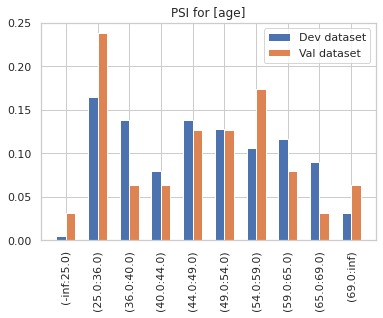

gender PSI: 0.00895


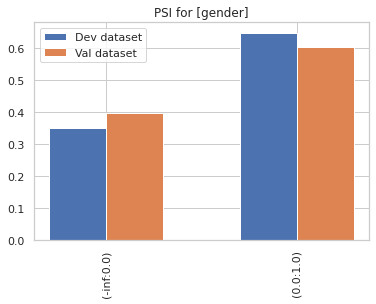

polyuria PSI: 0.0023


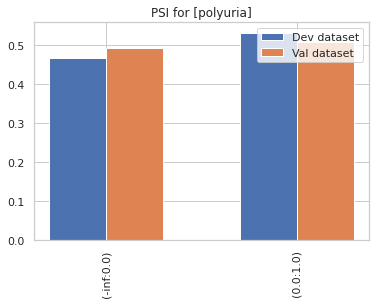

polydipsia PSI: 0.00227


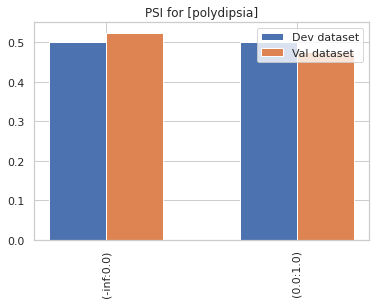

sudden_weight_loss PSI: 0.00226


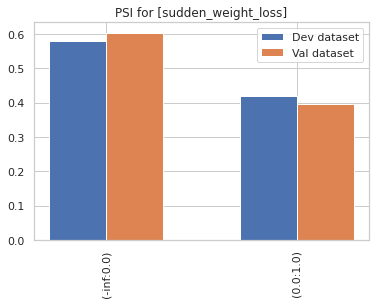

weakness PSI: 0.00697


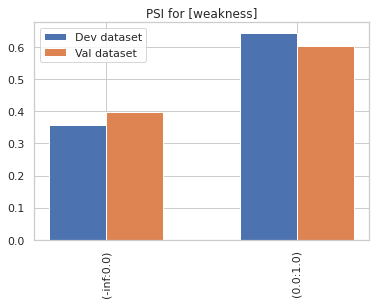

polyphagia PSI: 0.02062


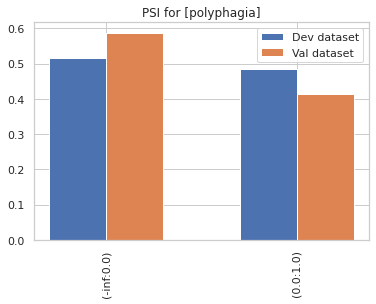

genital_thrush PSI: 0.00155


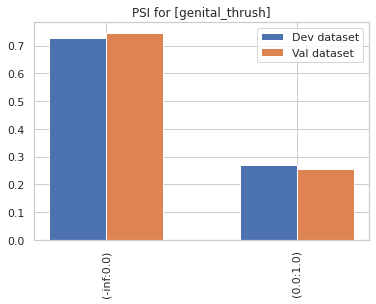

visual_blurring PSI: 0.11688


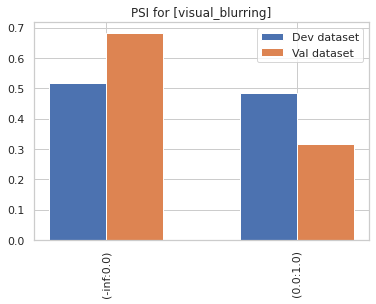

itching PSI: 0.14427


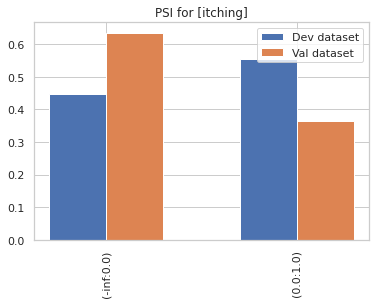

irritability PSI: 0.08199


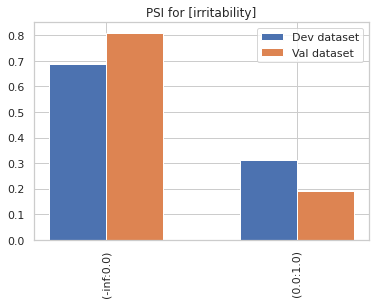

delayed_healing PSI: 0.05231


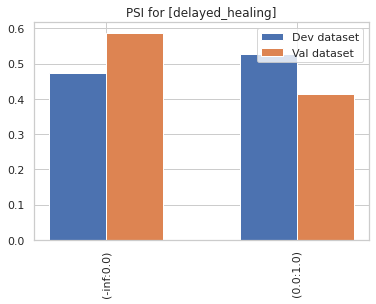

partial_paresis PSI: 2e-05


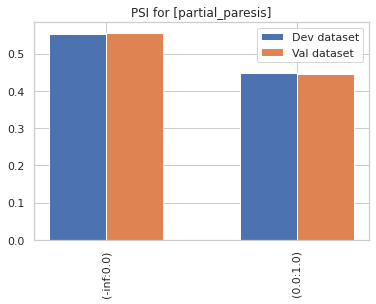

muscle_stiffness PSI: 0.00486


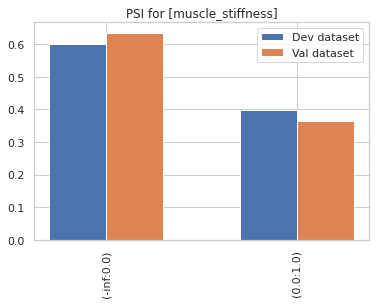

alopecia PSI: 0.00068


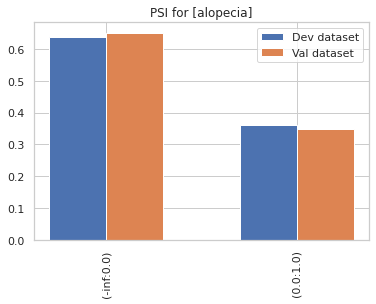

obesity PSI: 0.05768


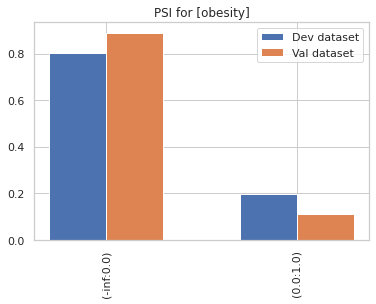

In [ ]:
PSI_list = []
for ind in X_train.columns.values:
  print(ind, end=' ')
  PSI_list.append(PSI_factor_analysis(X_train, X_test, ind))

Только признак 'age' говорит, что нужно перестроить модель, но это, скорее всего, из-за маленького размера отложенной выборки.

In [ ]:
print(PSI_list)

[0.2686, 0.00895, 0.0023, 0.00227, 0.00226, 0.00697, 0.02062, 0.00155, 0.11688, 0.14427, 0.08199, 0.05231, 2e-05, 0.00486, 0.00068, 0.05768]


Рассмотрим PSI для целевой переменной.

class PSI: 0.01206


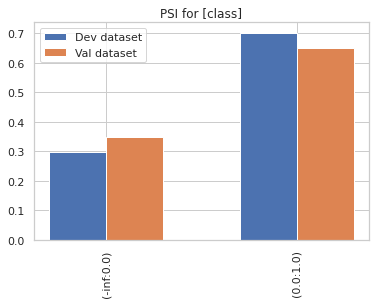

In [ ]:
print('class', end=' ')
psi_class = PSI_factor_analysis(pd.DataFrame(y_train), pd.DataFrame(y_test), 'class')

PSI для целевой переменной меньше 10%, поэтому можем считать модель стабильной.

В дальнейшем необходимо проведить анализ популяции с помощью индекса PSI, чтобы понять, когда необходимо будет перестроить модель. 

Полагаем, что модель устаревает не очень быстро, так как она использует основные симптомы болезни. Желательно провести повторное исследование через год, поскольку могут появиться новые медицинские открытия, связанные с диабетом. 

### Сегменты, на которых модель работает хуже или лучше, чем в среднем

Найдём такие наборы значений признаков, на которых модель работает плохо, средне и хорошо. 

Будем считать, что модель плохо работает на следующих объектах:
- принадлежащие к 0 классу, а вероятность принадлежности к 1 классу больше 0.4;
- принадлежащие к 1 классу, а вероятность принадлежности к 1 классу меньше 0.6;

Будем считать, что модель средне работает на следующих объектах:
- принадлежащие к 0 классу, а вероятность принадлежности к 1 классу от 0.2 до 0.4;
- принадлежащие к 1 классу, а вероятность принадлежности к 1 классу от 0.6 до 0.8;

Будем считать, что модель хорошо работает на следующих объектах:
- принадлежащие к 0 классу, а вероятность принадлежности к 1 классу от 0 до 0.2;
- принадлежащие к 1 классу, а вероятность принадлежности к 1 классу от 0.8 до 1;

In [ ]:
# Вероятность принадлежности объектов к первому классу
y_pred_forest_prob =  cv.best_estimator_.predict_proba(X_test)[:,1]
# истинные метки
y_test_array = np.array(y_test)

In [ ]:
# объекты, на которых модель работает плохо
bad_pred  = [i for i in range(len(y_test)) if (((y_test_array[i]==0) and (y_pred_forest_prob[i]>=0.4)) or ((y_test_array[i]==1) and (y_pred_forest_prob[i]<=0.6)))]
# объекты, на которых модель работает средне
mean_pred = [i for i in range(len(y_test)) if (((y_test_array[i]==0) and (y_pred_forest_prob[i]<0.4) and (y_pred_forest_prob[i]>0.2)) or ((y_test_array[i]==1) and (y_pred_forest_prob[i]<0.8) and (y_pred_forest_prob[i]>0.6)))]
# объекты, на которых модель работает хорошо
good_pred = [i for i in range(len(y_test)) if (((y_test_array[i]==0) and (y_pred_forest_prob[i]<=0.2)) or ((y_test_array[i]==1) and (y_pred_forest_prob[i]>=0.8)))]

In [ ]:
bad_pred = np.array(bad_pred)
mean_pred = np.array(mean_pred)
good_pred = np.array(good_pred)

In [ ]:
# функция, считающая взвешанное по классам среднее
# на вход dataframe с признаками объекта и метками классов
def weight_mean(df):
  N = df.shape[0] # количество всех объектов
  n = sum(df.iloc[:,-1]) # количество объектов класса 1
  m = N - n  # количество объектов класса 0
  # print((df[df.iloc[:,-1]==1]*m/N).sum().values)
  # print( (df[df.iloc[:,-1]==0]*n/N).sum().values)
  return(((df[df.iloc[:,-1]==1]/n).sum().values + (df[df.iloc[:,-1]==0]/m).sum().values)/2)


Получим dataframes, где будут объекты из отложенной выборки, на которых модель работает плохо(df_bad_pred), средне(df_mean_pred) и хорошо(df_good_pred).

In [ ]:
df_bad_pred = pd.DataFrame(np.concatenate((X_test.to_numpy()[bad_pred,:], y_test_array[bad_pred].reshape(1, len(bad_pred)).T), axis =1))
# df_bad_pred.mean(axis=0).values
df_bad_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,45,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,56,1,0,1,0,1,1,0,1,1,0,1,0,1,1,0,0
2,54,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0
3,28,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,25,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1
5,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,35,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
7,32,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1
8,60,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
9,34,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_good_pred = pd.DataFrame(np.concatenate((X_test.to_numpy()[good_pred,:], y_test_array[good_pred].reshape(1, len(good_pred)).T), axis =1))
# df_good_pred.mean(axis=0).values
df_good_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,55,1,1,1,1,1,0,1,0,0,1,0,1,0,0,0,1
1,57,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1
2,61,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1
3,65,0,1,1,0,1,1,0,0,1,0,0,1,1,0,0,1
4,55,0,1,0,1,0,0,1,1,1,0,1,1,0,0,0,1
5,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
6,34,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1
7,47,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
8,35,0,0,1,1,1,1,0,0,1,0,0,1,0,0,0,1
9,53,1,0,0,0,1,0,0,1,1,0,1,0,1,1,0,0


In [ ]:
df_mean_pred = pd.DataFrame(np.concatenate((X_test.to_numpy()[mean_pred,:], y_test_array[mean_pred].reshape(1, len(mean_pred)).T), axis =1))
# df_mean_pred.mean(axis=0).values
df_mean_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,70,1,0,1,1,1,1,0,1,1,1,0,0,0,1,0,1
1,65,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
2,39,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,48,0,0,0,1,1,0,0,1,1,0,1,1,0,0,0,1
4,70,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0,0
5,61,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0
6,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,57,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,1
8,49,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1
9,55,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0


Найдём усреднённые значения признаков для полученных dataframes: df_bad_pred, df_mean_pred и df_good_pred.

In [ ]:
mean_bad = weight_mean(df_bad_pred)
mean_mean = weight_mean(df_mean_pred)
mean_good = weight_mean(df_good_pred)

print('b: ', mean_bad)
print('m: ', mean_mean)
print('g: ', mean_good)

b:  [38.11904762  0.52380952  0.          0.07142857  0.21428571  0.45238095
  0.38095238  0.38095238  0.23809524  0.07142857  0.16666667  0.30952381
  0.14285714  0.14285714  0.30952381  0.33333333  0.5       ]
m:  [57.08333333  0.45238095  0.1547619   0.16666667  0.41666667  0.70238095
  0.23809524  0.29761905  0.4047619   0.70238095  0.23809524  0.45238095
  0.29761905  0.23809524  0.53571429  0.1547619   0.5       ]
g:  [4.76250e+01 7.81250e-01 4.68750e-01 4.21875e-01 2.65625e-01 4.68750e-01
 3.43750e-01 1.25000e-01 2.96875e-01 4.84375e-01 1.25000e-01 4.53125e-01
 3.43750e-01 3.75000e-01 4.68750e-01 4.68750e-02 5.00000e-01]


Запишем в dataframe усреднённые значения признаков для объектов, на которых модель работает плохо, средне и хорошо.

In [ ]:
df_all_mean = pd.DataFrame([mean_bad,mean_mean,mean_good])
df_all_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,38.119048,0.523810,0.000000,0.071429,0.214286,0.452381,0.380952,0.380952,0.238095,0.071429,0.166667,0.309524,0.142857,0.142857,0.309524,0.333333,0.5
1,57.083333,0.452381,0.154762,0.166667,0.416667,0.702381,0.238095,0.297619,0.404762,0.702381,0.238095,0.452381,0.297619,0.238095,0.535714,0.154762,0.5
2,47.625000,0.781250,0.468750,0.421875,0.265625,0.468750,0.343750,0.125000,0.296875,0.484375,0.125000,0.453125,0.343750,0.375000,0.468750,0.046875,0.5


Разделение объектов по сегментам происходит по признаку, если среднее значение этого признака либо возрастает, либо убывает при увеличении качества модели, то есть признак i будет разделять на сегменты, если:

df_all_mean[0,i]<df_all_mean[1,i]<df_all_mean[2,i] или df_all_mean[0,i]>df_all_mean[1,i]>df_all_mean[2,i]. 

In [ ]:
index_mean = []
for i in range(df_all_mean.shape[1]-1):
  if (df_all_mean.iloc[0,i]<df_all_mean.iloc[1,i] and df_all_mean.iloc[1,i]<df_all_mean.iloc[2,i]) or (df_all_mean.iloc[0,i]>df_all_mean.iloc[1,i] and df_all_mean.iloc[1,i]>df_all_mean.iloc[2,i]):
    index_mean.append(i)

index_mean = np.array(index_mean)
print(index_mean)

[ 2  3  7 11 12 13 15]


In [ ]:
X_test.columns[index_mean].values

array(['polyuria', 'polydipsia', 'genital_thrush', 'delayed_healing',
       'partial_paresis', 'muscle_stiffness', 'obesity'], dtype=object)

По этим признакам можно разбить объекты на сегменты: 'polyuria', 'polydipsia', 'genital_thrush', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'obesity'.

К сегменту, на которых модель работает хуже, чем в среднем, относятся те, у которых 
- нет полиурии (увеличенное образование мочи)
- нет полидипсии (неутолимая жажда)
- есть генитальная молочница
- нет медленного заживления ран
- нет частичных парезов (потеря мышечной силы)
- нет жесткости мышц
- есть ожирение

К сегменту, на которых модель работает лучше, чем в среднем, относятся те, у которых 
- есть полиурия (увеличенное образование мочи)
- есть полидипсия (неутолимая жажда)
- нет генитальной молочницы
- есть медленное заживление ран
- есть частичный парез (потеря мышечной силы)
- есть жесткость мышц
- нет ожирения

### Дополнительные свойства модели, актуальные для кейса

 - Поскольку практикующие врачи обычно ставят диагноз, основываясь на своем опыте и рассуждениях, основанных на знаниях, им довольно трудно принять расплывчатые и трудные для понимания модели при диагностике критического заболевания, которое связано с ценностей человеческих жизней. Итак, чтобы справиться с их сомнениями, нужна ***интерпретируемая модель*** машинного обучения. Одной из самых интерпретируемых моделей является дерево решений, но оно склонно к переобучению, поэтому используем случайный лес, который представляет из себя ансамбль из деревьев решений. Смещение ошибки у случайного леса примерно такое же, как и у дерева решений, а разброс ошибок -  меньше.

- Важна калибровка модели, так как важна уверенность модели в поставленном диагнозе(выходные данные метода pred_proba нужно напрямую интерпретировать как уровень достоверности).

- Линейность по факторам не обязательна.

## 3. Сохраняем модель в бинарный файл

In [ ]:
model_path = 'random_forest_diabet.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(cv.best_estimator_, file)

## 4. Загружаем модель и проверяем метрики

In [ ]:
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
loaded_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.56,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
print_metrics(y_test, loaded_model.predict(X_test))

f1_score: 0.9398
recall_score: 0.9512
precision_score: 0.9286
